## Dual Shot Face Detector (2018)

Paper: https://arxiv.org/abs/1810.10220

- Seems to have two backbones and combines information from both. 
- Seems to be state of the arty
- Allegedly kind of slow


![image](https://i.gyazo.com/7a7d72d07c1d7b56fce7b65afe3518b3.png)


In [70]:
import cv2
import torch
from pathlib import Path
from dsfd.detect import DSFDDetector
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib.patches as patches

If you would like to use this, you need to download the weights from the original repository. The Google Drive link is: 

- https://drive.google.com/file/d/1WeXlNYsM6dMP3xQQELI-4gxhwKUQxc3-/view?usp=sharing

They must be placed in `dsfd/weights/`

In [44]:
detector = DSFDDetector()

Finished loading model!


In [45]:
def read_frame_as_size(video_path, size=(128, 128)):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, size)
    capture.release()
    return frame

def read_frame(video_path):
    capture = cv2.VideoCapture(str(video_path))
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    capture.release()
    return frame


def read_all_frames(video_path):
    capture = cv2.VideoCapture(str(video_path))
    all_frames = []
    ret = True
    while True:
        ret, frame = capture.read()
        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            all_frames.append(frame)
        else:
            break
    
    capture.release()
    return all_frames

In [46]:
# This will return a tensor with shape [N, 5], where 
# N is number of faces 
# the five elements are [xmin, ymin, xmax, ymax, detection_confidence]





data = Path('../data')

# Two easy faces to ensure that we can get facial recognition working
easy1 = data/'dfdc_train_part_2/abmjszfycr_REAL.mp4'
easy2 = data/'dfdc_train_part_11/aqyvunegbf_REAL.mp4'

In [47]:
frame1 = read_frame(easy1)
frame2 = read_frame(easy2)

In [63]:
detections1 = detector.detect_face(frame1, confidence_threshold=.5, shrink=1.0)
detections2 = detector.detect_face(frame2, confidence_threshold=.5, shrink=1.0)

In [64]:
def plot_detections(img, detections, with_keypoints=True):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.grid(False)
    ax.imshow(img)
    
    if isinstance(detections, torch.Tensor):
        detections = detections.cpu().numpy()

    if detections.ndim == 1:
        detections = np.expand_dims(detections, axis=0)

    print("Found %d faces" % detections.shape[0])
        
    for i in range(detections.shape[0]):
        
        xmin = detections[i, 0]
        ymin = detections[i, 1]
        xmax = detections[i, 2]
        ymax = detections[i, 3]

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        
    plt.show()

Found 1 faces


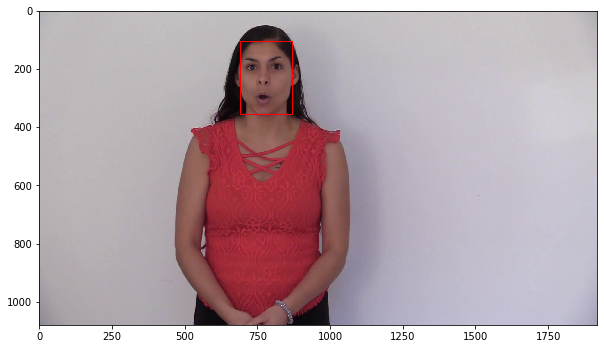

In [65]:
plot_detections(frame1, detections1, with_keypoints=False)

Found 1 faces


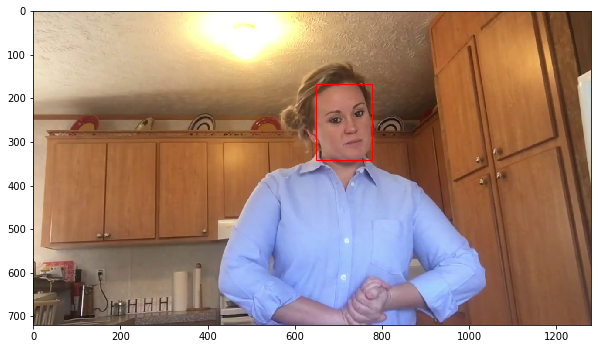

In [66]:
plot_detections(frame2, detections2, with_keypoints=False)

# Get all faces in all frames

In [67]:
def show_faces(faces, rows, columns, figsize=(20, 20)):
    
    axes = plt.subplots(rows, columns, figsize=figsize)[1]
    
    for row in range(rows):
        rowOffset = row * columns
        
        for column in range(columns):
            if rowOffset + column < len(faces):
                face = faces[rowOffset + column]
                axes[row,column].imshow(face)

In [109]:
def get_cropped_faces(frame, detections):
    
    faces = []
    
    for detection in detections:
       
        xmin = max(0, int(detection[0])) # Don't try to crop less than 0
        ymin = max(0, int(detection[1])) # Don't try to crop less than 0
        xmax = min(frame.shape[1], int(detection[2]))
        ymax = min(frame.shape[0], int(detection[3]))
        
        face = frame[ymin:ymax, xmin:xmax]
        
        faces.append(face)
    
    return faces

In [110]:
def predict_all_frames(frames):
    
    predictions = []
    for frame in tqdm_notebook(frames):
        detections =  detector.detect_face(frame, confidence_threshold=.5, shrink=1.0)
        
        faces = get_cropped_faces(frame, detections)
        
        if len(faces) > 0:
            predictions.extend(faces)
            
    return predictions

In [111]:
all_frames1 = read_all_frames(easy1)
all_frames2 = read_all_frames(easy2)

In [112]:
all_faces1 = predict_all_frames(all_frames1)
all_faces2 = predict_all_frames(all_frames2)

/home/josh/anaconda3/envs/dl/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


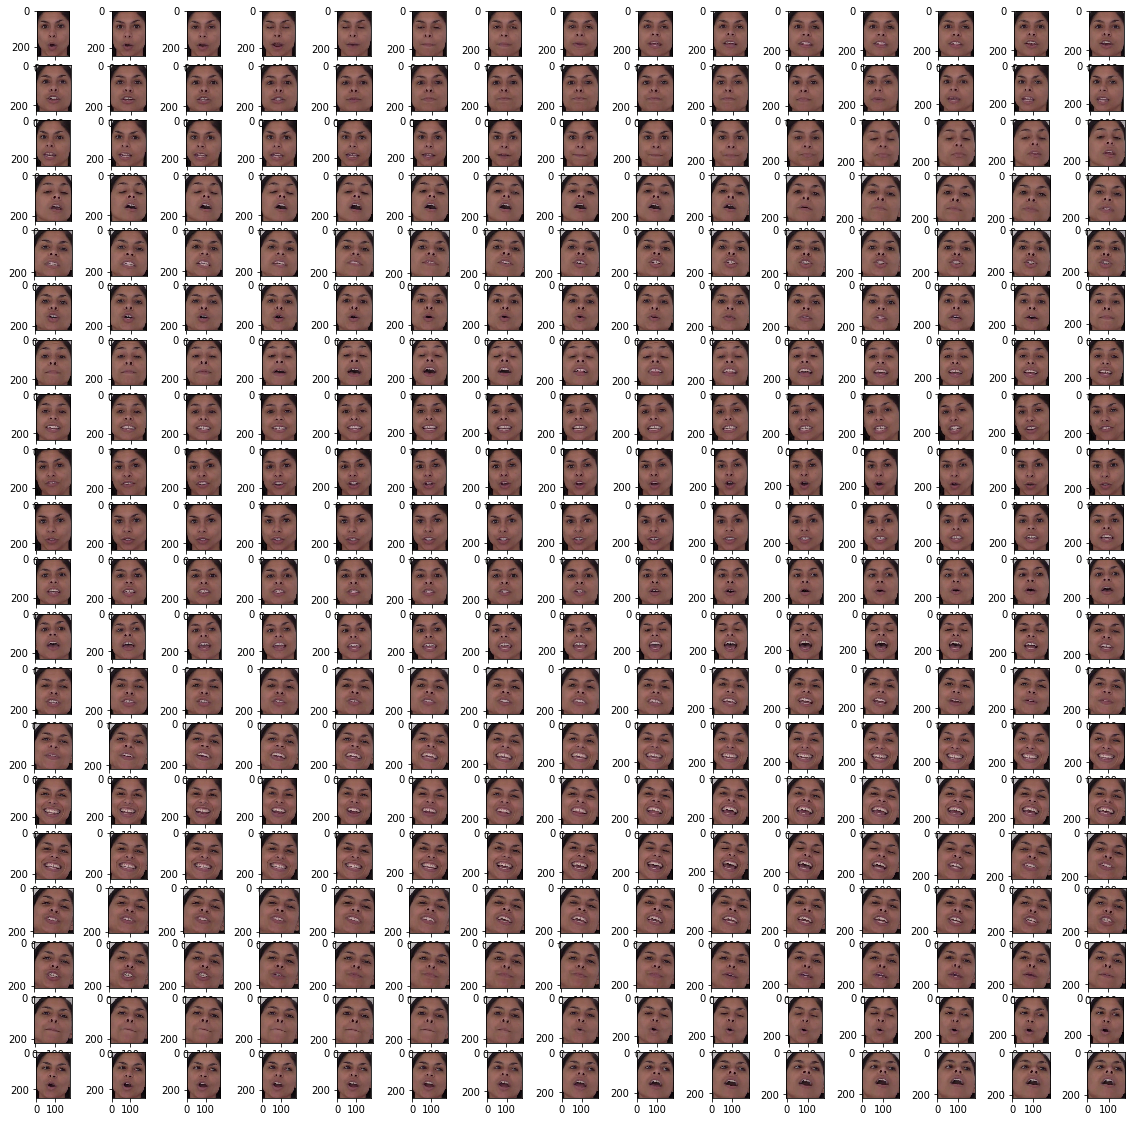

In [113]:
show_faces(all_faces1, 20, 15)

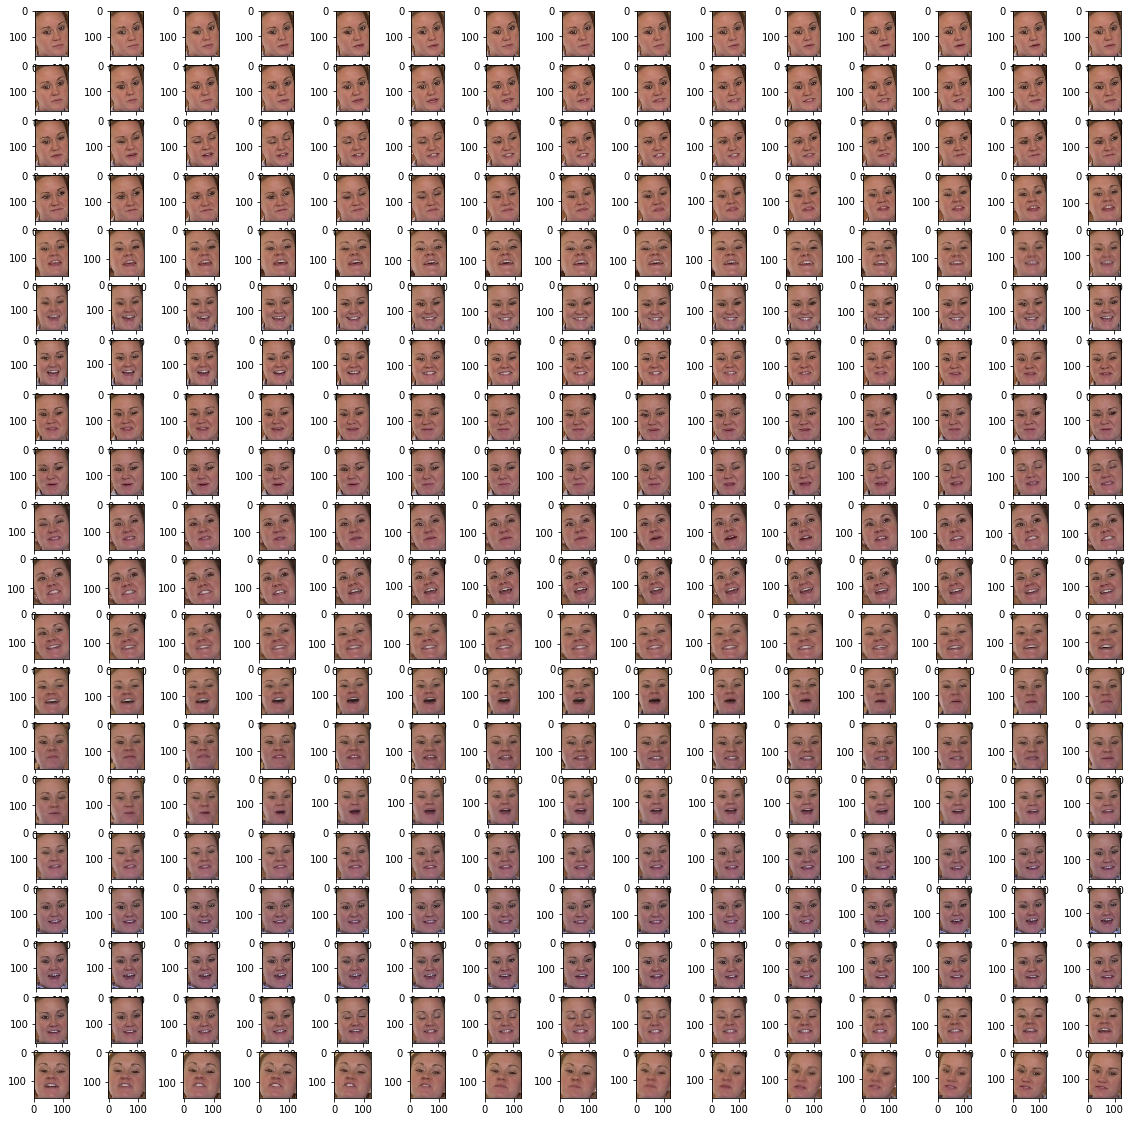

In [114]:
show_faces(all_faces2, 20, 15)

Some takeaways: 
- This approach seems to work as well as BlazeFace on these two "easy" videos.
- This approach is 5x slower than MTCNN and 50x slower than BlazeFace
- This approach uses ResNet-152 as its backbone which is a pretty large (read: memory hog) backbone

Maybe this approach will work better on very hard to find faces? We'll have to investigate further.